In [1]:
import dynalearn
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tqdm8
import os

In [2]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

def empty_graph(n):
    g = nx.empty_graph(n)
    g.name = 'empty_n{0}'.format(n)
    return g

def BA_tree_graph(n):
    g = nx.barabasi_albert_graph(n, 1)
    g.name = 'ba_tree_n{0}'.format(n)
    return g

def ER_graph(n, p):
    g = nx.gnp_random_graph(n, p)
    g.name = 'er_n{0}_p{1}'.format(n, p)
    return g

In [67]:
# Generating the network
n_nodes = 100
inf_prob = 0.1
rec_prob = 0.08
T = 100
batch_size = None

train_sample = 20000
val_sample = 1000

approach = "gatpred"
graph = complete_graph(n_nodes)
# graph = chain_graph(n_nodes)
# graph = empty_graph(n_nodes)
# graph = star_graph(n_nodes)
# graph = BA_tree_graph(n_nodes)
# graph = ER_graph(n_nodes, 0.5)

f_prefix = 'data/' + approach + "_" + graph.name + "_SIS_inf{0}_rec{1}".format(inf_prob, rec_prob)
if not os.path.exists(f_prefix):
    os.mkdir(f_prefix)


train_generator = dynalearn.datasets.SISMultiStateGenerator(graph, inf_prob, rec_prob, batch_size,
                                                  online=False, init_active=None,
                                                  shuffle=True, with_structure=True)
val_generator = dynalearn.datasets.SISMultiStateGenerator(graph, inf_prob, rec_prob, batch_size,
                                                online=False, init_active=None,
                                                shuffle=False, with_structure=True)
test_generator = dynalearn.datasets.SISMultiStateGenerator(graph, inf_prob, rec_prob, batch_size,
                                                online=False, init_active=None,
                                                shuffle=False, with_structure=True)
train_generator.generate(train_sample, T, tqdm.tqdm_notebook)
val_generator.generate(val_sample, T, tqdm.tqdm_notebook)
test_generator.generate(val_sample, T, tqdm.tqdm_notebook)

In [5]:
x, y= next(iter(train_generator))

In [6]:
x[0].shape, x[1].shape


((10, 2), (10, 10))

In [49]:
from __future__ import absolute_import

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Dropout, LeakyReLU


class GraphAttention(Layer):

    def __init__(self,
                 F_,
                 attn_heads=1,
                 attn_heads_reduction='concat',  # {'concat', 'average'}
                 dropout_rate=0.5,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 attn_kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 attn_kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 attn_kernel_constraint=None,
                 **kwargs):
        if attn_heads_reduction not in {'concat', 'average'}:
            raise ValueError('Possbile reduction methods: concat, average')

        self.F_ = F_  # Number of output features (F' in the paper)
        self.attn_heads = attn_heads  # Number of attention heads (K in the paper)
        self.attn_heads_reduction = attn_heads_reduction  # Eq. 5 and 6 in the paper
        self.dropout_rate = dropout_rate  # Internal dropout rate
        self.activation = activations.get(activation)  # Eq. 4 in the paper
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.attn_kernel_initializer = initializers.get(attn_kernel_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = regularizers.get(attn_kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.attn_kernel_constraint = constraints.get(attn_kernel_constraint)
        self.supports_masking = False

        # Populated by build()
        self.kernels = []       # Layer kernels for attention heads
        self.biases = []        # Layer biases for attention heads
        self.attn_kernels = []  # Attention kernels for attention heads

        if attn_heads_reduction == 'concat':
            # Output will have shape (..., K * F')
            self.output_dim = self.F_ * self.attn_heads
        else:
            # Output will have shape (..., F')
            self.output_dim = self.F_

        super(GraphAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        F = int(input_shape[0][-1])

        # Initialize weights for each attention head
        for head in range(self.attn_heads):
            # Layer kernel
            kernel = self.add_weight(shape=(F, int(self.F_)),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint,
                                     name='kernel_{}'.format(head))
            self.kernels.append(kernel)

            # # Layer bias
            if self.use_bias:
                bias = self.add_weight(shape=(int(self.F_), ),
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       constraint=self.bias_constraint,
                                       name='bias_{}'.format(head))
                self.biases.append(bias)

            # Attention kernels
            attn_kernel_self = self.add_weight(shape=(int(self.F_), 1),
                                               initializer=self.attn_kernel_initializer,
                                               regularizer=self.attn_kernel_regularizer,
                                               constraint=self.attn_kernel_constraint,
                                               name='attn_kernel_self_{}'.format(head),)
            attn_kernel_neighs = self.add_weight(shape=(int(self.F_), 1),
                                                 initializer=self.attn_kernel_initializer,
                                                 regularizer=self.attn_kernel_regularizer,
                                                 constraint=self.attn_kernel_constraint,
                                                 name='attn_kernel_neigh_{}'.format(head))
            self.attn_kernels.append([attn_kernel_self, attn_kernel_neighs])
        self.built = True

    def call(self, inputs):
        X = inputs[0]  # Node features (N x F)
        A = inputs[1]  # Adjacency matrix (N x N)

        outputs = []
        for head in range(self.attn_heads):
            kernel = self.kernels[head]  # W in the paper (F x F')
            attention_kernel = self.attn_kernels[head]  # Attention kernel a in the paper (2F' x 1)

            # Compute inputs to attention network
            features = K.dot(X, kernel)  # (N x F')

            # Compute feature combinations
            # Note: [[a_1], [a_2]]^T [[Wh_i], [Wh_2]] = [a_1]^T [Wh_i] + [a_2]^T [Wh_j]
            attn_for_self = K.dot(features, attention_kernel[0])    # (N x 1), [a_1]^T [Wh_i]
            attn_for_neighs = K.dot(features, attention_kernel[1])  # (N x 1), [a_2]^T [Wh_j]

            # Attention head a(Wh_i, Wh_j) = a^T [[Wh_i], [Wh_j]]
            dense = attn_for_self + K.transpose(attn_for_neighs)  # (N x N) via broadcasting

            # Add nonlinearty
            dense = LeakyReLU(alpha=0.2)(dense)

            # Mask values before activation (Vaswani et al., 2017)
            mask = -10e9 * (1.0 - A)
            dense += mask

            # Apply softmax to get attention coefficients
            dense = K.softmax(dense)  # (N x N)

            # Apply dropout to features and attention coefficients
            dropout_attn = Dropout(self.dropout_rate)(dense)  # (N x N)
            dropout_feat = Dropout(self.dropout_rate)(features)  # (N x F')

            # Linear combination with neighbors' features
            node_features = K.dot(dropout_attn, dropout_feat)  # (N x F')
            node_features = node_features + dropout_feat # skip connection
            

            if self.use_bias:
                node_features = K.bias_add(node_features, self.biases[head])

            # Add output of attention head to final output
            outputs.append(node_features)

        # Aggregate the heads' output according to the reduction method
        if self.attn_heads_reduction == 'concat':
            output = K.concatenate(outputs)  # (N x KF')
        else:
            output = K.mean(K.stack(outputs), axis=0)  # N x F')

        output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = input_shape[0][0], self.output_dim
        return output_shape


In [50]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Softmax, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from dynalearn.keras_models.base import MarkovPredictor


class GATMarkovPredictor(MarkovPredictor):
    def __init__(self, graph, n_hidden, n_heads,
                 weight_decay=1e-4, dropout=0.6, **kwargs):
        if type(n_hidden) is int:
            n_hidden = [n_hidden]
        if type(n_heads) is int:
            n_heads = [n_heads] * len(n_hidden)
        elif len(n_heads) != len(n_hidden):
            raise ValueError
        
        self.graph = graph
        self.n_nodes = graph.number_of_nodes()
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.weight_decay = weight_decay
        self.dropout = dropout
        super(GATMarkovPredictor, self).__init__(**kwargs)


    def get_model(self):
        N = self.graph.number_of_nodes()
        inputs = Input(shape=(2, ))
        adj = Input(shape=(N, ))

        x = inputs
        for i in range(len(self.n_hidden)):
            att = GraphAttention(self.n_hidden[i],
                                 attn_heads=self.n_heads[i],
                                 attn_heads_reduction='concat',  # {'concat', 'average'}
                                 dropout_rate=0.5,
                                 activation='linear',
                                 kernel_regularizer=l2(self.weight_decay))
            x = att([x, adj])

        outputs = Dense(2, activation='softmax')(x)

        return Model([inputs, adj], outputs=outputs)

In [69]:
n_hidden = [64]
n_heads = 8
wd = 5e-4
dropout = 0.3
model = GATMarkovPredictor(graph, n_hidden, n_heads, weight_decay=wd, dropout=dropout)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
graph_attention_13 (GraphAttent (None, 512)          2560        input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            1026        graph_attention_13[0][0]         
Total para

In [70]:

lr = 1e-3

optimizer = keras.optimizers.Adam(lr=lr)
loss = keras.losses.categorical_crossentropy
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,
                                               cooldown=5, patience=5,
                                               verbose=1),
             keras.callbacks.ModelCheckpoint(os.path.join(f_prefix, 'model'),
                                             monitor='val_acc',
                                             save_best_only=True,
                                             verbose=0)]
model._model.compile(optimizer, loss, metrics=['accuracy'])


In [71]:
history = model._model.fit_generator(train_generator,
                                     steps_per_epoch=1000,
                                     validation_data=val_generator,
                                     validation_steps=val_sample,
                                     epochs=10,
                                     initial_epoch=0,
                                     verbose=1,
                                     callbacks=callbacks)

Epoch 1/10
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0614 - acc: 0.9897 - val_loss: 0.0551 - val_acc: 0.9912

In [72]:
def increment_bit(x):

    val = x * 1
    i = np.where(x==0)[0][0]
    index = np.arange(len(x))
    val[index <= i] = 0
    val[i] = 1

    return val

def get_all_states(graph):
    N = graph.number_of_nodes()
    all_states = np.zeros([2**N, N])
    for i in range(1, 2**N):
        all_states[i, :] = increment_bit(all_states[i - 1, :])
    return all_states

def get_sample_from_all_states(graph, num_sample):
    N = graph.number_of_nodes()
    sampled_states = np.zeros([num_sample, N])
    for i in range(num_sample):
        sampled_states[i, :] = np.random.randint(0, 2, size=N)
    return sampled_states
    

def convert_to_multistate(states, n_state):
    new_states = np.zeros([*states.shape, n_state])
    new_states[states == 0] = [1, 0]
    new_states[states == 1] = [0, 1]
    return new_states
    

def get_SISLogTransProb(graph, states, infection_prob, recovery_prob):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    p = np.zeros([states.shape[0], N])
    for i, s in enumerate(states):
        local_p = np.zeros(N)
        inf_neighbors = np.matmul(A, s)
        local_p[s==0] = 1 - (1 - infection_prob)**inf_neighbors[s==0]
        local_p[s==1] = 1 - recovery_prob
        p[i, :] = np.log(local_p + 1e-15)
    return p
        
def get_SISMarkovMatrix(graph, infection_prob,recovery_prob):
    states = get_all_states(graph)
    logprob = get_SISLogTransProb(graph, states, infection_prob, recovery_prob)
    log_mm = np.matmul(states, logprob.T) + np.matmul(1 - states,np.log(1 - np.exp(logprob)).T)
    return log_mm


def get_LearnedMarkovMatrix(graph, model):
    states = get_all_states(graph)
    N = graph.number_of_nodes()
    A = nx.to_numpy_array(graph)
    log_mm = np.zeros([len(states), len(states)])
    if batch_size is None:
        for i, s in enumerate(states):
            s = convert_to_multistate(s, 2)
            logprob = np.log(model.predict([s, A]) + 1e-15)[:, 1]
            log_mm[:, i] = np.matmul(states, logprob).reshape(states.shape[0]) \
                         + np.matmul(1 - states,np.log(1 - np.exp(logprob))).reshape(states.shape[0])
    else:
        logprob = np.log(model.predict(states) + 1e-15)
        log_mm = np.matmul(states, logprob) + np.matmul(1 - states,np.log(1 - np.exp(logprob)))
    
    return log_mm
    
    
def bit_to_value(array):
    d = array.shape[0]
    bit = 2**np.arange(d)
    return np.sum(array * bit)

def get_dataOccurence(graph, generator):
    N = graph.number_of_nodes()
    past = get_all_states(graph)
    occurence = np.zeros([2**N, 2**N])
    
    for i in range(len(generator)):
        inputs = generator.data_input[i,:, 1]
        targets = generator.data_target[i,:, 1]
        i, j = int(bit_to_value(targets)), int(bit_to_value(inputs))
        
        occurence[i, j] += 1
    
    sparcity_matrix = np.zeros(occurence.shape)
    sparcity_matrix[occurence>0] = 1
    return np.log(occurence / np.sum(occurence) + 1e-15), np.sum(sparcity_matrix) / 2**(2*N)


def get_dataMarkovMatrix(occurence, real_mm, learned_mm):
    n, m = occurence.shape
    indata_sismm = []
    indata_learnedmm = []
    notindata_sismm = []
    notindata_learnedmm = []


    for i in range(n):
        for j in range(n):    
            if occurence[i, j] > -20:
                indata_sismm.append(max(real_mm[i, j], -100))
                indata_learnedmm.append(learned_mm[i, j])
            else:
                notindata_sismm.append(max(real_mm[i, j], -100))
                notindata_learnedmm.append(learned_mm[i, j])
    return np.array([indata_sismm, indata_learnedmm]).T,\
           np.array([notindata_sismm, notindata_learnedmm]).T

In [73]:
real_mm = get_SISMarkovMatrix(graph, inf_prob, rec_prob)
learned_mm = get_LearnedMarkovMatrix(graph, model._model)
data_occurence, sparcity = get_dataOccurence(graph, train_generator)
indata, notindata = get_dataMarkovMatrix(data_occurence, real_mm, learned_mm)

ValueError: Maximum allowed dimension exceeded

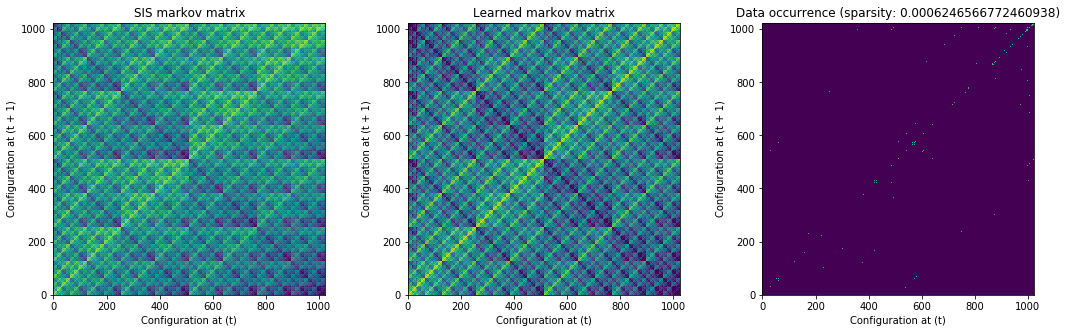

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].imshow(real_mm, origin='lower', vmin=-20, vmax=0)
ax[0].set_title('SIS markov matrix')
ax[0].set_xlabel('Configuration at (t)')
ax[0].set_ylabel('Configuration at (t + 1)')
ax[1].imshow(learned_mm, origin='lower', vmin=-20, vmax=0)
ax[1].set_title('Learned markov matrix')
ax[1].set_xlabel('Configuration at (t)')
ax[1].set_ylabel('Configuration at (t + 1)')
ax[2].imshow(data_occurence, origin='lower', vmin=-20, vmax=0)
ax[2].set_title('Data occurrence (sparsity: {0})'.format(sparcity))
ax[2].set_xlabel('Configuration at (t)')
ax[2].set_ylabel('Configuration at (t + 1)')
plt.show()

In [74]:

def get_SISLocalProbability(graph, infection_prob, recovery_prob, states, progress_bar=None):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    
    prob = np.zeros([states.shape[0], N])

    inf_neighbors = np.matmul(A, states[:, :, 1].T).T
    states = states[:, :, 1]
    
    sus_prob = {i: [] for i in range(N)}
    inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Probabilities')
    for i in range(states.shape[0]):
        s = states[i, :]
        
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            if s[j] == 0:
                sus_prob[int(inf)].append((1 - infection_prob)**inf)
                inf_prob[int(inf)].append(1 - (1 - infection_prob)**inf)
            else:
                sus_prob[int(inf)].append(recovery_prob)
                inf_prob[int(inf)].append(1 - recovery_prob)

    if progress_bar:
        bar.close()
    
    return sus_prob, inf_prob

def get_learnedLocalProbability(graph, model, states, progress_bar=None):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    
    prob = np.zeros([states.shape[0], N])

    if batch_size is None:
        if progress_bar:
            bar = progress_bar(range(states.shape[0]), 'Transitions')
        for i, s in enumerate(states):
            p = model.predict([s, A], steps=1) + 1e-15
            prob[i, :] = p[:, 1]
            if progress_bar:
                bar.update()
        
        if progress_bar:
            bar.close()
    else:
        prob = model.predict(states) + 1e-15
    
    sus_prob = {i: [] for i in range(N)}
    inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Probabilities')
    for i in range(states.shape[0]):
        s = states[i, :, 1]
        
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            sus_prob[int(inf)].append(1 - prob[i, j])
            inf_prob[int(inf)].append(prob[i, j])
    
    if progress_bar:
        bar.close()
    
    return sus_prob, inf_prob
        

In [76]:
# states = convert_to_multistate(get_all_states(graph), 2)
states = convert_to_multistate(get_sample_from_all_states(graph, 1000), 2)

real_sus, real_inf = get_SISLocalProbability(graph, inf_prob, rec_prob, states)
learned_sus, learned_inf = get_learnedLocalProbability(graph, model._model, states, tqdm.tqdm_notebook)


In [77]:
def plot_prob_vs_l(prob, ax, marker, linestyle, color, fill_color=None, label=None):
    if fill_color is None:
        fill_color = color
        
            
    keys = prob.keys()
    x = np.array([i for i in keys])
    y = np.array([np.mean(prob[i]) if np.sum(prob[i]) > 0 else 0 for i in keys])
    err_y = np.array([np.std(prob[i]) if np.sum(prob[i]) > 0 else 0 for i in keys])
    ax.fill_between(x, y - err_y, y + err_y, color=fill_color, alpha=0.3)
    ax.plot(x, y, marker=marker, ls=linestyle, c=color, label=label, lw=3)
    return x, y

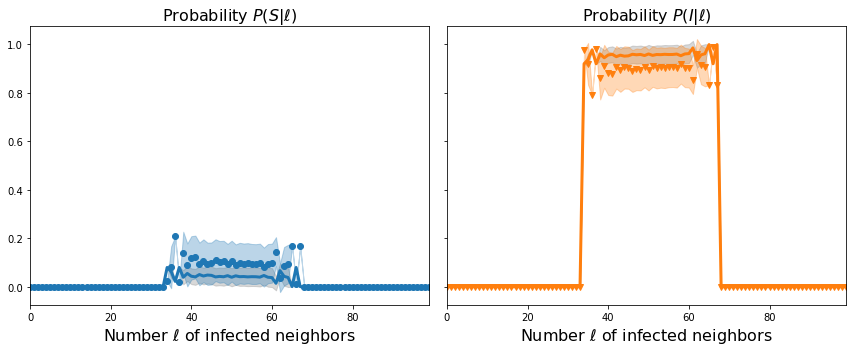

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

x_real_sus, y_real_sus = plot_prob_vs_l(real_sus, ax[0], 'None', '-', '#1f77b4', 'grey')
x_real_inf, y_real_inf = plot_prob_vs_l(real_inf, ax[1], 'None', '-', '#ff7f0e', 'grey')

x_learned_sus, y_learned_sus = plot_prob_vs_l(learned_sus, ax[0], 'o', 'None', '#1f77b4')
x_learned_inf, y_learned_inf = plot_prob_vs_l(learned_inf, ax[1], 'v', 'None', '#ff7f0e')

ax[0].set_title(r'Probability $P(S| \ell)$', fontsize=16)
ax[1].set_title(r'Probability $P(I| \ell)$', fontsize=16)
ax[0].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[1].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[0].set_xlim([0, max(dict(graph.degree).values())])
# plt.savefig(f_prefix + 'val_transition_num_infected.png')
plt.tight_layout()
plt.show()

## Changing graph

In [79]:
er_graph = ER_graph(n_nodes, 0.3)

er_real_sus, er_real_inf  = get_SISLocalProbability(er_graph, inf_prob, rec_prob, states)

er_learned_sus, er_learned_inf = get_learnedLocalProbability(er_graph, model._model,
                                                             states, tqdm.tqdm_notebook)

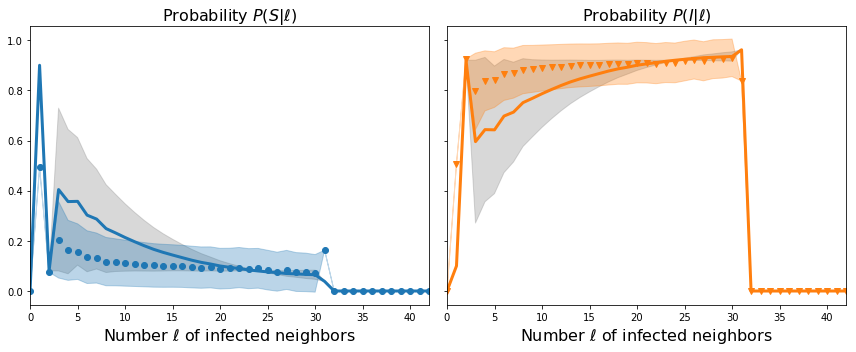

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

plot_prob_vs_l(er_real_sus, ax[0], 'None', '-', '#1f77b4', 'grey')
plot_prob_vs_l(er_real_inf, ax[1], 'None', '-', '#ff7f0e', 'grey')

plot_prob_vs_l(er_learned_sus, ax[0], 'o', 'None', '#1f77b4')
plot_prob_vs_l(er_learned_inf, ax[1], 'v', 'None', '#ff7f0e')

ax[0].set_title(r'Probability $P(S| \ell)$', fontsize=16)
ax[1].set_title(r'Probability $P(I| \ell)$', fontsize=16)
ax[0].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[1].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[0].set_xlim([0, max(dict(er_graph.degree).values())])
# plt.savefig(f_prefix + 'val_transition_num_infected.png')
plt.tight_layout()
plt.show()